# Tutorial on Bures-Wasserstien Flow Matching

Here we present a tutorial on how to run BW-FM for generating Guassian disribution

In [1]:
import jax
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
from bwflowmatching import BuresWassersteinFlowMatching

2024-10-01 12:14:35.102533: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Set costum colormap for plotting:

In [3]:
from matplotlib.colors import ListedColormap

In [4]:
from matplotlib.colors import ListedColormap

hot_cmap = plt.cm.get_cmap('hot')
colors = hot_cmap(np.linspace(0, 1, 256))
colors[0:8, 3] = 0 #np.array([1, 1, 1, 1])
colors[8:180, 3] = np.linspace(0.0, 1.0, 180 - 8)
colors[180:, 3] = 1
custom_cmap = ListedColormap(colors)

/tmp/ipykernel_104731/1375846857.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hot_cmap = plt.cm.get_cmap('hot')


# Generate synthetic data

Draw Gaussians centered on a spiral

In [6]:
def generate_spiral_gaussians(N, n_rotations=3, variance_scale=0.05):
    # Generate spiral points
    t = np.sqrt(np.linspace(0, n_rotations, N+5))[5:]
    
    # Convert to polar coordinates
    theta = 2 * np.pi * t
    r = t
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    means = np.column_stack((x, y))
    covariances = []
    for x,y in means:
        direction = np.array([-x, -y])
        direction /= np.linalg.norm(direction)
        
        perpendicular = np.array([-direction[1], direction[0]])
        cov_matrix = variance_scale * (0.9 * np.outer(direction, direction) + 
                                        0.1 * np.outer(perpendicular, perpendicular))
        covariances.append(cov_matrix)

    return means, np.asarray(covariances)
# Generate and plot the Gaussians
N = 128
means, covariances = generate_spiral_gaussians(N, n_rotations = 10, variance_scale = 0.01)

Plot data

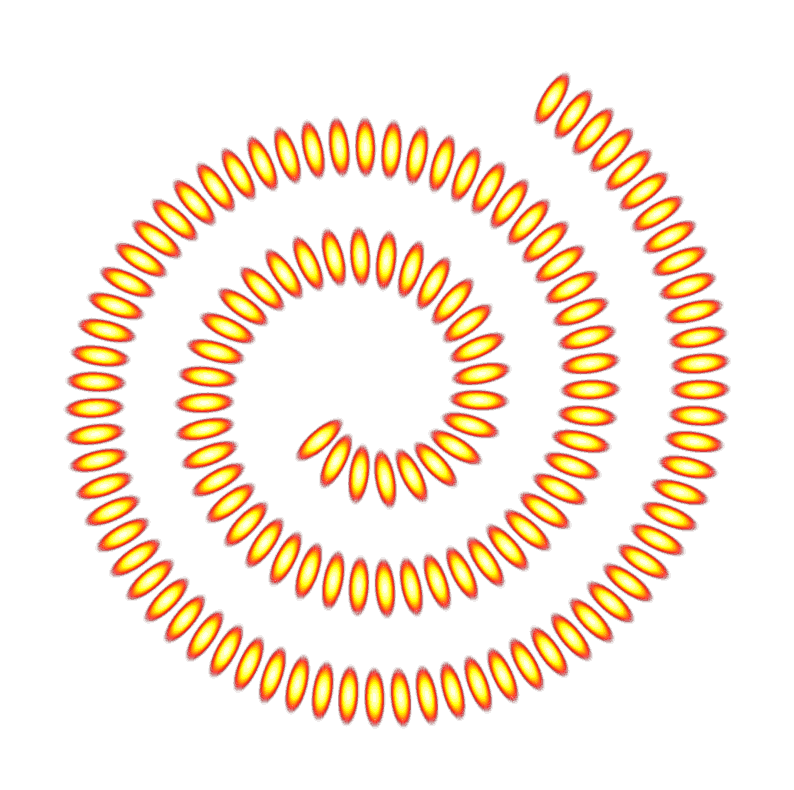

In [7]:
num_points = 500
x = np.linspace(-3, 3.5, num_points)
y = np.linspace(-3.5, 3.5, num_points)
X, Y = np.meshgrid(x, y)

# Combine X and Y into a single array of points
pos = np.dstack((X, Y))

# Calculate the density for each Gaussian
Z = np.zeros_like(X)
for mean, cov in zip(means, covariances):
    mvn = scipy.stats.multivariate_normal(mean, cov/4) # Divide by 4 to make plotting nicer
    Z += mvn.pdf(pos)
    

fig, ax = plt.subplots(figsize=(10, 10))

# Plot contourf
contour = ax.contourf(X, Y, np.log(Z + 0.00001), levels=20, cmap = custom_cmap, zorder = 2)
ax.axis('equal')
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Run Bures-Wasserstein Flow Matching

In [19]:
BuresWassersteinModel = BuresWassersteinFlowMatching(means = means, covariances = covariances)

Train Model & Plot loss curve

In [20]:
BuresWassersteinModel.train(batch_size = 256, training_steps=100000)

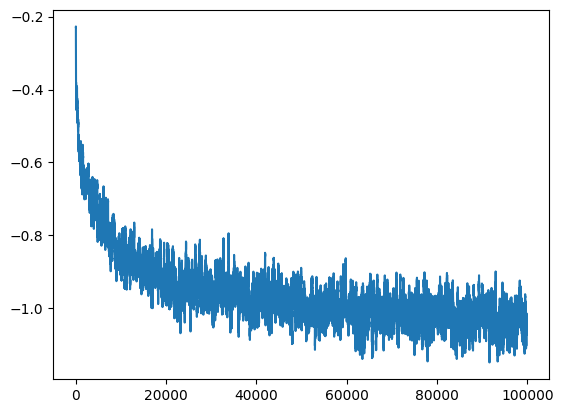

In [11]:
loss_smooth = np.convolve(np.log(BuresWassersteinModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)

## Generated Flows

Set Initial Key

In [22]:
key = jax.random.PRNGKey(0)

Run Flow for 1000 timesteps

In [23]:
subkey, key = jax.random.split(key)
generated_samples = BuresWassersteinModel.generate_samples(512, timesteps=1000, key = subkey)

100%|██████████| 999/999 [00:04<00:00, 227.17it/s]


Plot generated Samples

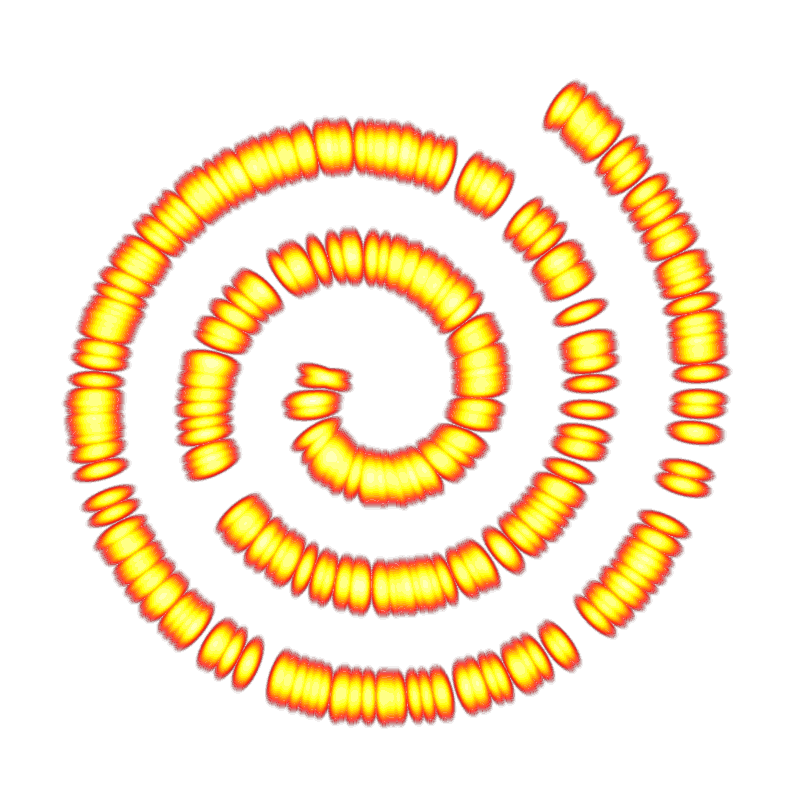

In [24]:
num_points = 500
x = np.linspace(-3, 3.5, num_points)
y = np.linspace(-3.5, 3.5, num_points)
X, Y = np.meshgrid(x, y)

# Combine X and Y into a single array of points
pos = np.dstack((X, Y))

# Calculate the density for each Gaussian
Z = np.zeros_like(X)
for mean, cov in zip(generated_samples[-1][0], generated_samples[-1][1]):
    mvn = scipy.stats.multivariate_normal(mean, cov/4)
    Z += mvn.pdf(pos)
    

fig, ax = plt.subplots(figsize=(10, 10))
contour = ax.contourf(X, Y, np.log(Z + 0.00001), levels=20, cmap=custom_cmap)
ax.axis('equal')
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
plt.show()